In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
from sqlalchemy import create_engine
from keras.models import Sequential
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from numpy import NaN
from tqdm import tqdm
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import psycopg2
import urllib
import keras
import os

<font size="30">Connect to the database</font>


In [2]:
#connect to the database


In [3]:
#connect to the database
conn = psycopg2.connect(database='Value_Added_data_drought',
                        user="postgres",
                        password="1!qaz2@wsx",
                        host="140.134.51.64",
                        port="5432")
engine = create_engine('postgresql+psycopg2://postgres:%s@140.134.51.64/Value_Added_data_drought'%urllib.parse.quote_plus('1!qaz2@wsx'))
cur = conn.cursor()


query = f'select * from public."FCU_grid_to_area_code_1km_37134"'
DFFF = pd.read_sql(query,con=engine)

<font size="30">data processing(2010/01/01-2022/12/31)</font>


In [5]:
#data cleaning process
def data_processing(dataset) -> pd.DataFrame:
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
    start_date = pd.to_datetime('2010-01-01')
    end_date = pd.to_datetime('2022-12-31')
    dataset_2020_2022 = dataset.query('date >= @start_date and date <= @end_date')
    dataset_2020_2022 = dataset_2020_2022[['date','grid','value']]
    dataset_2020_2022['value'].fillna(int(0),inplace=True)
    dataset_2020_2022['value'] = dataset_2020_2022['value'].astype('float')
    dataset_2020_2022 = dataset_2020_2022.groupby('grid').apply(lambda x: x.sort_values('date', ascending=True)).reset_index(drop=True)
    return dataset_2020_2022

#get the DSCI,SRSI, SPI, SSI data from the database 
def get_data_from_database(database_table:str)->pd.DataFrame:
    query = f'select * from "{database_table}"'
    df = pd.read_sql(query,con=engine)
    return df

df_DSCI = get_data_from_database('New_fcu_DSCI_City_mode_a_day')

#get the DSCI 
database_table = 'New_fcu_DSCI_City_mode_a_day'
query = f'select * from "{database_table}"'
df_DSCI = pd.read_sql(query,con=engine)

#get the SRSI
database_table = 'New_wra_City_srsi_day'
query = f'select * from "{database_table}"'
City_srsi = pd.read_sql(query,con=engine)

#get the SPI
database_table = 'New_qpesum_City_spi_day'
query = f'select * from "{database_table}"'
City_spi = pd.read_sql(query,con=engine)

#get the SSI
database_table = 'New_wra_City_ssi_day'
query = f'select * from "{database_table}"'
df_SSI = pd.read_sql(query,con=engine)

#conduct cleaning process
df_DSCI_2020_2022 = data_processing(df_DSCI)
df_SSI_2020_2022 = data_processing(df_SSI)
City_spi_2020_2022 = data_processing(City_spi)
City_srsi_2020_2022 = data_processing(City_srsi)

<font size="30">Merge each city code with its DSCI/SSI/SPI/SRSI values</font>

In [6]:
# Merge DataFrames outside the loop
merged_df_base = df_DSCI_2020_2022.merge(df_SSI_2020_2022, on=['date', 'grid'], how='left', suffixes=('_DSCI', '_SSI'))
merged_df_base = merged_df_base.merge(City_spi_2020_2022, on=['date', 'grid'], how='left', suffixes=('_SSI', '_SPI'))
merged_df_base = merged_df_base.merge(City_srsi_2020_2022, on=['date', 'grid'], how='left', suffixes=('_SPI', '_SRSI'))

output_dict = {}  # Initialize the output dictionary

# Iterate over grids
for i in tqdm(df_DSCI_2020_2022['grid']):
    merged_df = merged_df_base[merged_df_base['grid'] == i].copy()  # Filter merged_df_base for current grid

    # Drop columns with all NaN values
    if np.isnan(merged_df['value_SSI']).all():
        merged_df.drop(columns='value_SSI', inplace=True)
    if np.isnan(merged_df['value_SRSI']).all():
        merged_df.drop(columns='value_SRSI', inplace=True)
    else:
        merged_df[['value_SSI','value_SRSI']] = merged_df[['value_SSI','value_SRSI']].astype('float')

    output_dict[i] = merged_df

# Process the individual merged DataFrames
for i, merged_df in output_dict.items():
    # Perform any further operations or analysis on each merged_df
    print(f"Output for grid {i}:")
    print(merged_df)
    print("-------------------")


100%|██████████| 90212/90212 [01:36<00:00, 935.54it/s] 

Output for grid 10002:
           date   grid  value_DSCI  value_SPI
0    2010-01-01  10002         1.0      -0.67
1    2010-01-02  10002         1.0      -0.74
2    2010-01-03  10002         1.0      -0.49
3    2010-01-04  10002         1.0      -0.49
4    2010-01-05  10002         1.0      -0.43
...         ...    ...         ...        ...
4743 2022-12-27  10002         0.0       0.29
4744 2022-12-28  10002         0.0       0.40
4745 2022-12-29  10002         0.0       0.51
4746 2022-12-30  10002         0.0       0.50
4747 2022-12-31  10002         0.0       0.52

[4748 rows x 4 columns]
-------------------
Output for grid 10004:
           date   grid  value_DSCI  value_SSI  value_SPI  value_SRSI
4748 2010-01-01  10004         1.5      -1.49      -0.10       -0.25
4749 2010-01-02  10004         1.5      -1.45       0.19       -0.46
4750 2010-01-03  10004         1.5      -1.40       0.39       -0.47
4751 2010-01-04  10004         1.0      -1.24       0.39       -0.49
4752 2010-01

In [32]:
df_68000_DSCI = output_dict[68000][['date','value_DSCI']]
df_68000_DSCI['value_DSCI(t+1)'] = df_68000_DSCI['value_DSCI'].shift(-1)
df_68000_DSCI['value_DSCI(t-1)'] = df_68000_DSCI['value_DSCI'].shift(1)
df_68000_DSCI['value_DSCI(t-2)'] = df_68000_DSCI['value_DSCI'].shift(2)
df_68000_DSCI['value_DSCI(t-3)'] = df_68000_DSCI['value_DSCI'].shift(3)
df_68000_DSCI['value_DSCI(t-4)'] = df_68000_DSCI['value_DSCI'].shift(4)
df_68000_DSCI['value_DSCI(t-5)'] = df_68000_DSCI['value_DSCI'].shift(5)
df_68000_DSCI['value_DSCI(t-6)'] = df_68000_DSCI['value_DSCI'].shift(6)
df_68000_DSCI['value_DSCI(t-7)'] = df_68000_DSCI['value_DSCI'].shift(7)
df_68000_DSCI['value_DSCI(t-8)'] = df_68000_DSCI['value_DSCI'].shift(8)
df_68000_DSCI['value_DSCI(t-9)'] = df_68000_DSCI['value_DSCI'].shift(9)
df_68000_DSCI['value_DSCI(t-10)'] = df_68000_DSCI['value_DSCI'].shift(10)
df_68000_DSCI['value_DSCI(t-11)'] = df_68000_DSCI['value_DSCI'].shift(11)
df_68000_DSCI['value_DSCI(t-12)'] = df_68000_DSCI['value_DSCI'].shift(12)
df_68000_DSCI['value_DSCI(t-13)'] = df_68000_DSCI['value_DSCI'].shift(13)
df_68000_DSCI['value_DSCI(t-14)'] = df_68000_DSCI['value_DSCI'].shift(14)
df_68000_DSCI['value_DSCI(t-15)'] = df_68000_DSCI['value_DSCI'].shift(15)
df_68000_DSCI['value_DSCI(t-16)'] = df_68000_DSCI['value_DSCI'].shift(16)
df_68000_DSCI['value_DSCI(t-17)'] = df_68000_DSCI['value_DSCI'].shift(17)
df_68000_DSCI['value_DSCI(t-18)'] = df_68000_DSCI['value_DSCI'].shift(18)
df_68000_DSCI['value_DSCI(t-19)'] = df_68000_DSCI['value_DSCI'].shift(19)
df_68000_DSCI['value_DSCI(t-20)'] = df_68000_DSCI['value_DSCI'].shift(20)
df_68000_DSCI['value_DSCI(t-21)'] = df_68000_DSCI['value_DSCI'].shift(21)
df_68000_DSCI['value_DSCI(t-22)'] = df_68000_DSCI['value_DSCI'].shift(22)
df_68000_DSCI['value_DSCI(t-23)'] = df_68000_DSCI['value_DSCI'].shift(23)
df_68000_DSCI['value_DSCI(t-24)'] = df_68000_DSCI['value_DSCI'].shift(24)
df_68000_DSCI['value_DSCI(t-25)'] = df_68000_DSCI['value_DSCI'].shift(25)
df_68000_DSCI['value_DSCI(t-26)'] = df_68000_DSCI['value_DSCI'].shift(26)
df_68000_DSCI['value_DSCI(t-27)'] = df_68000_DSCI['value_DSCI'].shift(27)
df_68000_DSCI['value_DSCI(t-28)'] = df_68000_DSCI['value_DSCI'].shift(28)
df_68000_DSCI['value_DSCI(t-29)'] = df_68000_DSCI['value_DSCI'].shift(29)
df_68000_DSCI['value_DSCI(t-30)'] = df_68000_DSCI['value_DSCI'].shift(30)
df_68000_DSCI.drop(columns='value_DSCI',inplace=True)
df_68000_DSCI.dropna(inplace=True)
df_68000_DSCI

C:\Users\tangkai\AppData\Local\Temp\ipykernel_9600\779161303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_68000_DSCI['value_DSCI(t+1)'] = df_68000_DSCI['value_DSCI'].shift(-1)
C:\Users\tangkai\AppData\Local\Temp\ipykernel_9600\779161303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_68000_DSCI['value_DSCI(t-1)'] = df_68000_DSCI['value_DSCI'].shift(1)
C:\Users\tangkai\AppData\Local\Temp\ipykernel_9600\779161303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,date,value_DSCI(t+1),value_DSCI(t-1),value_DSCI(t-2),value_DSCI(t-3),value_DSCI(t-4),value_DSCI(t-5),value_DSCI(t-6),value_DSCI(t-7),value_DSCI(t-8),...,value_DSCI(t-21),value_DSCI(t-22),value_DSCI(t-23),value_DSCI(t-24),value_DSCI(t-25),value_DSCI(t-26),value_DSCI(t-27),value_DSCI(t-28),value_DSCI(t-29),value_DSCI(t-30)
85494,2010-01-31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.50,1.50,1.50
85495,2010-02-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.50,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.50,1.50
85496,2010-02-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.50,0.50,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.50
85497,2010-02-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.50,0.50,0.50,0.50,1.00,1.00,1.00,1.00,1.00,1.00
85498,2010-02-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.50,0.50,0.50,0.50,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90206,2022-12-26,0.33,0.33,0.33,0.00,0.33,0.33,0.33,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90207,2022-12-27,0.33,0.33,0.33,0.33,0.00,0.33,0.33,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90208,2022-12-28,0.33,0.33,0.33,0.33,0.33,0.00,0.33,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90209,2022-12-29,0.00,0.33,0.33,0.33,0.33,0.33,0.00,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33


Build up the model.

In [33]:
X = df_68000_DSCI[df_68000_DSCI.columns[2:]]
y = df_68000_DSCI['value_DSCI(t+1)']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create the LightGBM dataset
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',  # Use 'regression' for numeric targets
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 5,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_leaves': 50,  # Adjust this parameter
    'max_depth': 10,  # Adjust this parameter
}
# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
# Train the model
num_boost_round = 100
model = lgb.train(params, train_data, num_boost_round=num_boost_round)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

Evaluate the performance of the model.

In [35]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)
# For regression tasks, calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)
# Alternatively, you can calculate other evaluation metrics such as R-squared (R2), mean absolute error (MAE), etc.
print("Mean Squared Error (MSE):", mse)
print("Mean Squared Error (RMSE):", rmse)

R-squared: 0.8889156381087446
Mean Squared Error (MSE): 0.036176633630105336


,date,grid,value,level,id,value(t-1),value(t-2),value(t-3),value(t-4),value(t-5),...,value(t-21),value(t-22),value(t-23),value(t-24),value(t-25),value(t-26),value(t-27),value(t-28),value(t-29),value(t-30)
0,2023-01-01,68000,0.00,0.0,181203,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,68000,0.00,0.0,181222,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,68000,0.00,0.0,181241,0.00,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,68000,0.00,0.0,181260,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,68000,0.00,0.0,181279,0.00,0.00,0.00,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2023-05-26,68000,0.67,1.0,183958,0.67,0.67,0.67,1.00,1.00,...,1.00,1.00,1.0,1.0,1.0,0.67,0.67,0.67,0.67,0.67
146,2023-05-27,68000,0.67,1.0,183977,0.67,0.67,0.67,0.67,1.00,...,1.00,1.00,1.0,1.0,1.0,1.00,0.67,0.67,0.67,0.67
147,2023-05-28,68000,0.67,1.0,183996,0.67,0.67,0.67,0.67,0.67,...,1.00,1.00,1.0,1.0,1.0,1.00,1.00,0.67,0.67,0.67
148,2023-05-29,68000,0.67,1.0,184015,0.67,0.67,0.67,0.67,0.67,...,0.67,1.00,1.0,1.0,1.0,1.00,1.00,1.00,0.67,0.67


In [42]:
true_val = df_DSCI[(df_DSCI['date'].between('2019-01-01','2019-12-31')) & (df_DSCI['grid'] == i)].reset_index(drop=True).sort_values('date',ascending=True)
true_val['value(t-1)'] = true_val['value'].shift(1)
true_val['value(t-2)'] = true_val['value'].shift(2)
true_val['value(t-3)'] = true_val['value'].shift(3)
true_val['value(t-4)'] = true_val['value'].shift(4)
true_val['value(t-5)'] = true_val['value'].shift(5)
true_val['value(t-6)'] = true_val['value'].shift(6)
true_val['value(t-7)'] = true_val['value'].shift(7)
true_val['value(t-8)'] = true_val['value'].shift(8)
true_val['value(t-9)'] = true_val['value'].shift(9)
true_val['value(t-10)'] = true_val['value'].shift(10)
true_val['value(t-11)'] = true_val['value'].shift(11)
true_val['value(t-12)'] = true_val['value'].shift(12)
true_val['value(t-13)'] = true_val['value'].shift(13)
true_val['value(t-14)'] = true_val['value'].shift(14)
true_val['value(t-15)'] = true_val['value'].shift(15)
true_val['value(t-16)'] = true_val['value'].shift(16)
true_val['value(t-17)'] = true_val['value'].shift(17)
true_val['value(t-18)'] = true_val['value'].shift(18)
true_val['value(t-19)'] = true_val['value'].shift(19)
true_val['value(t-20)'] = true_val['value'].shift(20)
true_val['value(t-21)'] = true_val['value'].shift(21)
true_val['value(t-22)'] = true_val['value'].shift(22)
true_val['value(t-23)'] = true_val['value'].shift(23)
true_val['value(t-24)'] = true_val['value'].shift(24)
true_val['value(t-25)'] = true_val['value'].shift(25)
true_val['value(t-26)'] = true_val['value'].shift(26)
true_val['value(t-27)'] = true_val['value'].shift(27)
true_val['value(t-28)'] = true_val['value'].shift(28)
true_val['value(t-29)'] = true_val['value'].shift(29)
true_val['value(t-30)'] = true_val['value'].shift(30)
true_val

,date,grid,value,level,id,value(t-1),value(t-2),value(t-3),value(t-4),value(t-5),...,value(t-21),value(t-22),value(t-23),value(t-24),value(t-25),value(t-26),value(t-27),value(t-28),value(t-29),value(t-30)
0,2019-01-01,68000,1.00,1.0,153444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,68000,1.00,1.0,153463,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,68000,0.67,1.0,153482,1.00,1.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,68000,0.67,1.0,153501,0.67,1.00,1.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-05,68000,0.67,1.0,153520,0.67,0.67,1.00,1.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,68000,0.33,0.0,160284,0.33,0.33,0.33,0.33,0.33,...,0.67,0.67,1.00,1.00,1.00,1.00,1.33,1.33,1.33,1.33
361,2019-12-28,68000,0.33,0.0,160303,0.33,0.33,0.33,0.33,0.33,...,0.33,0.67,0.67,1.00,1.00,1.00,1.00,1.33,1.33,1.33
362,2019-12-29,68000,0.33,0.0,160322,0.33,0.33,0.33,0.33,0.33,...,0.33,0.33,0.67,0.67,1.00,1.00,1.00,1.00,1.33,1.33
363,2019-12-30,68000,0.33,0.0,160341,0.33,0.33,0.33,0.33,0.33,...,0.33,0.33,0.33,0.67,0.67,1.00,1.00,1.00,1.00,1.33


In [49]:
for_prediction

,value(t-1),value(t-2),value(t-3),value(t-4),value(t-5),value(t-6),value(t-7),value(t-8),value(t-9),value(t-10),...,value(t-21),value(t-22),value(t-23),value(t-24),value(t-25),value(t-26),value(t-27),value(t-28),value(t-29),value(t-30)
4,0.67,0.67,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#predict the next day from the starting date
for_prediction = true_val[(true_val['date'].between('2019-01-05','2019-01-05'))].iloc[:,5:]
#X_sparse = csr_matrix(for_prediction)
ans = model.predict(for_prediction)
ans = [round(i,0) for i in ans]
ans # value for 2019/01/06

[1.0]

In [52]:
true_val[true_val['date'] == '2019-01-06']

,date,grid,value,level,id,value(t-1),value(t-2),value(t-3),value(t-4),value(t-5),...,value(t-21),value(t-22),value(t-23),value(t-24),value(t-25),value(t-26),value(t-27),value(t-28),value(t-29),value(t-30)
5,2019-01-06,68000,0.67,1.0,153539,0.67,0.67,0.67,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font size="30">Train the data</font>

10002
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

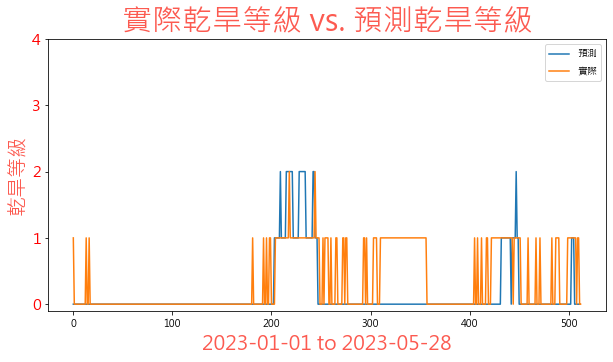

10004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

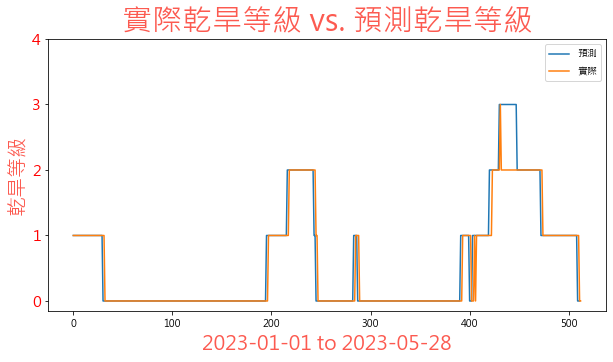

10005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

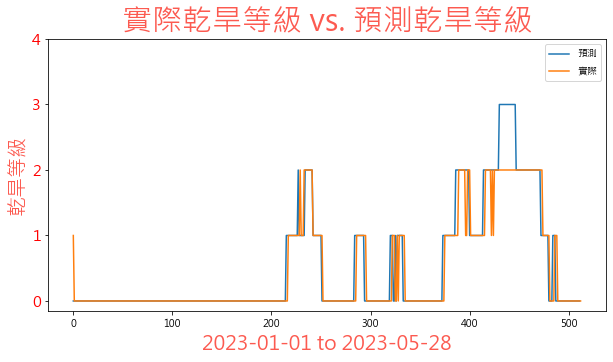

10007
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

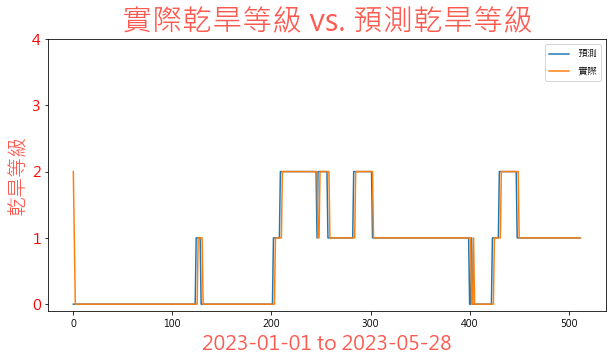

10008
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

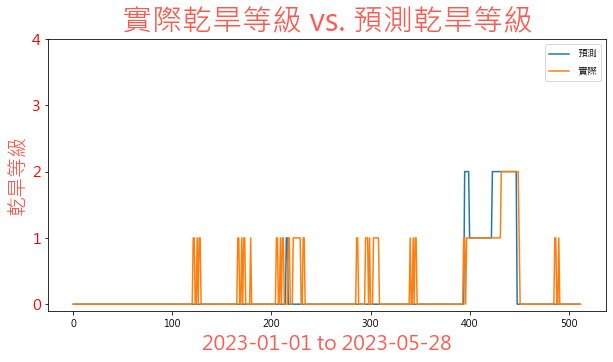

10009
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

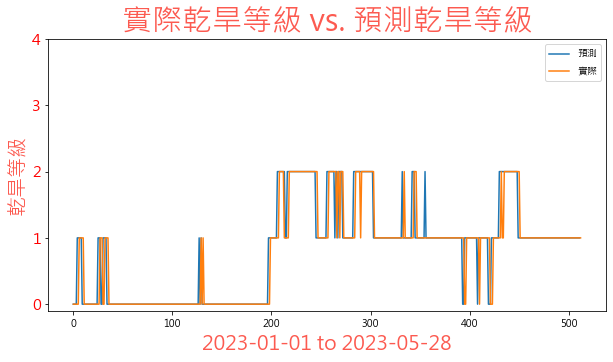

10010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

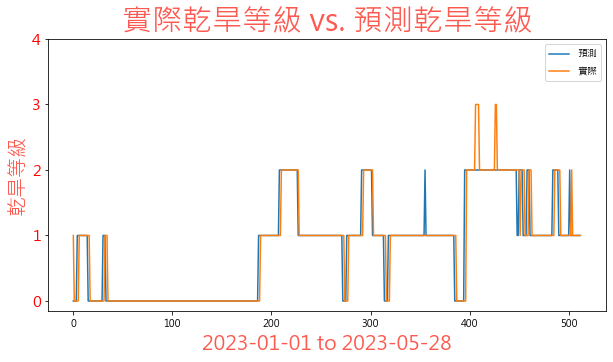

10013
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

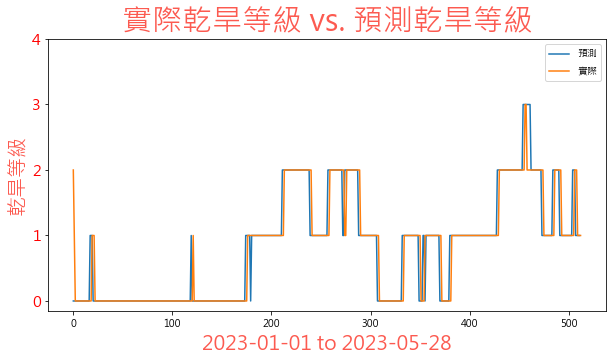

10014
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

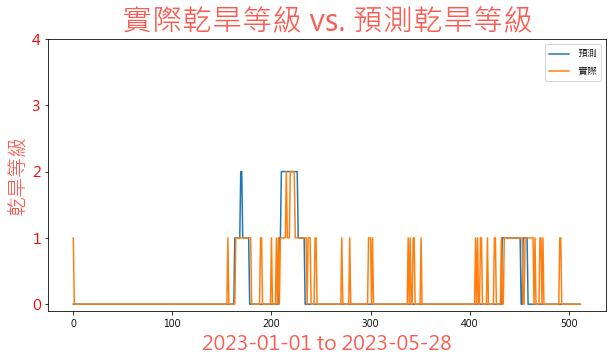

10015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

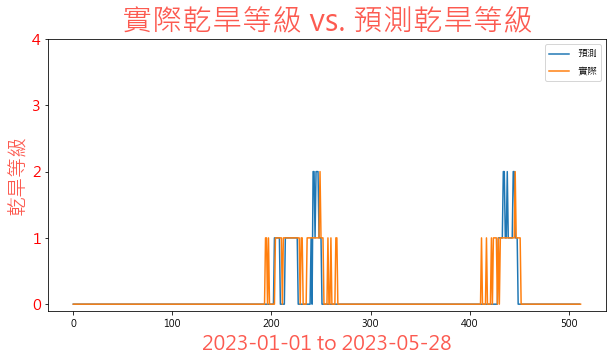

10017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

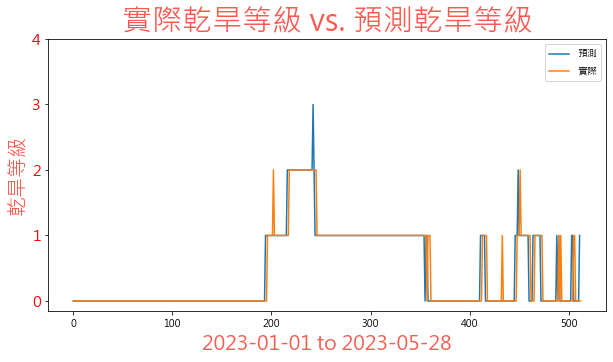

10018
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

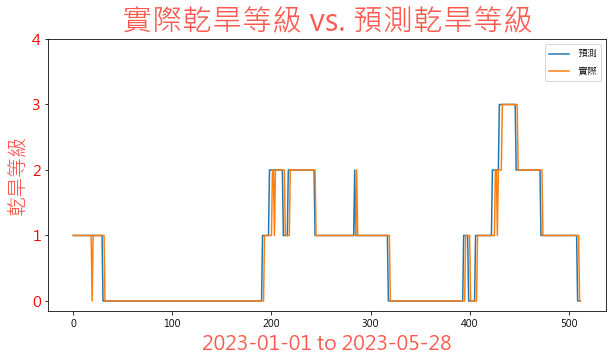

10020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

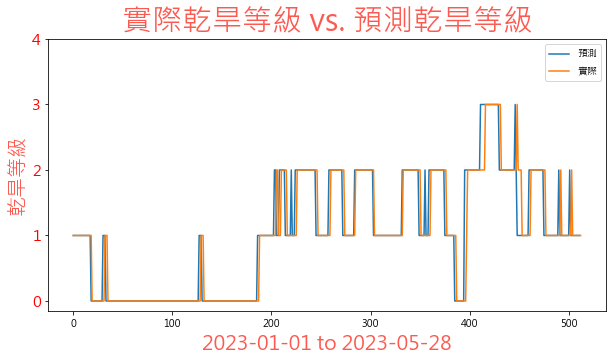

63000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

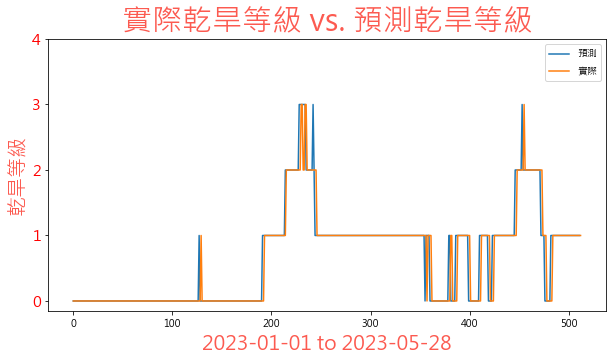

64000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

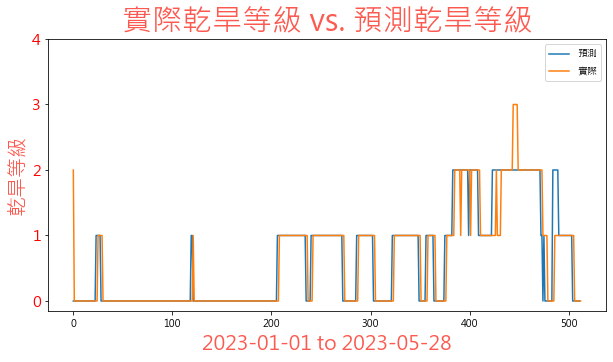

65000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

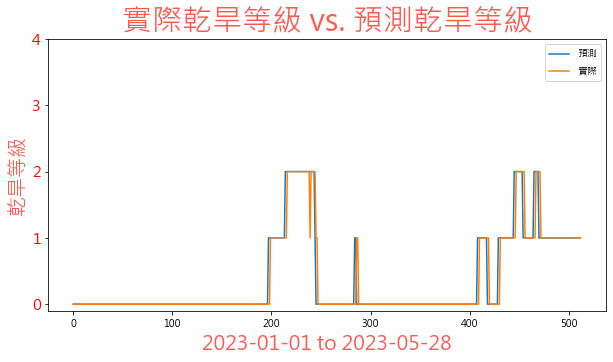

66000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

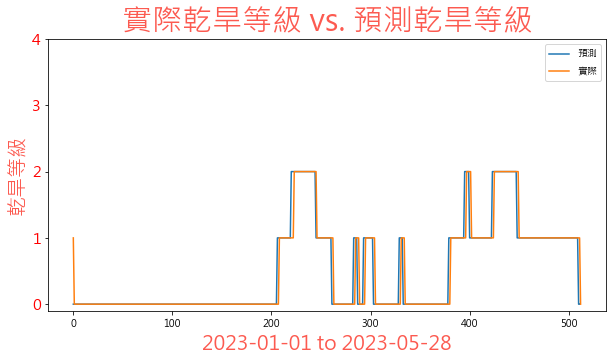

67000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

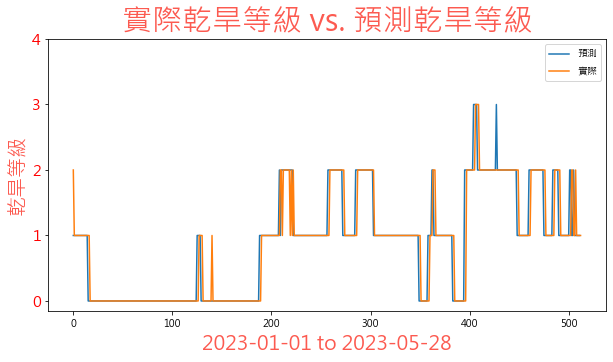

68000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

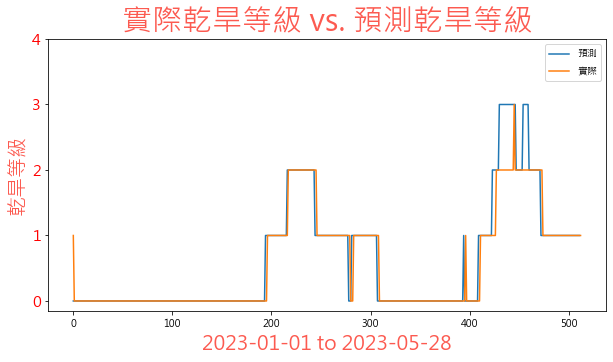

In [72]:
for i, merged_df in output_dict.items():
    df_train = output_dict[i].copy()
    print(i)
    df_train = df_train[['date','value_DSCI']]
    df_train['value_DSCI(t-1)'] = df_train['value_DSCI'].shift(1)
    df_train['value_DSCI(t-2)'] = df_train['value_DSCI'].shift(2)
    df_train['value_DSCI(t-3)'] = df_train['value_DSCI'].shift(3)
    df_train['value_DSCI(t-4)'] = df_train['value_DSCI'].shift(4)
    df_train['value_DSCI(t-5)'] = df_train['value_DSCI'].shift(5)
    df_train['value_DSCI(t-6)'] = df_train['value_DSCI'].shift(6)
    df_train['value_DSCI(t-7)'] = df_train['value_DSCI'].shift(7)
    df_train['value_DSCI(t-8)'] = df_train['value_DSCI'].shift(8)
    df_train['value_DSCI(t-9)'] = df_train['value_DSCI'].shift(9)
    df_train['value_DSCI(t-10)'] = df_train['value_DSCI'].shift(10)
    df_train['value_DSCI(t-11)'] = df_train['value_DSCI'].shift(11)
    df_train['value_DSCI(t-12)'] = df_train['value_DSCI'].shift(12)
    df_train['value_DSCI(t-13)'] = df_train['value_DSCI'].shift(13)
    df_train['value_DSCI(t-14)'] = df_train['value_DSCI'].shift(14)
    df_train['value_DSCI(t-15)'] = df_train['value_DSCI'].shift(15)
    df_train['value_DSCI(t-16)'] = df_train['value_DSCI'].shift(16)
    df_train['value_DSCI(t-17)'] = df_train['value_DSCI'].shift(17)
    df_train['value_DSCI(t-18)'] = df_train['value_DSCI'].shift(18)
    df_train['value_DSCI(t-19)'] = df_train['value_DSCI'].shift(19)
    df_train['value_DSCI(t-20)'] = df_train['value_DSCI'].shift(20)
    df_train['value_DSCI(t-21)'] = df_train['value_DSCI'].shift(21)
    df_train['value_DSCI(t-22)'] = df_train['value_DSCI'].shift(22)
    df_train['value_DSCI(t-23)'] = df_train['value_DSCI'].shift(23)
    df_train['value_DSCI(t-24)'] = df_train['value_DSCI'].shift(24)
    df_train['value_DSCI(t-25)'] = df_train['value_DSCI'].shift(25)
    df_train['value_DSCI(t-26)'] = df_train['value_DSCI'].shift(26)
    df_train['value_DSCI(t-27)'] = df_train['value_DSCI'].shift(27)
    df_train['value_DSCI(t-28)'] = df_train['value_DSCI'].shift(28)
    df_train['value_DSCI(t-29)'] = df_train['value_DSCI'].shift(29)
    df_train['value_DSCI(t-30)'] = df_train['value_DSCI'].shift(30)
    X = df_train[df_train.columns[2:]]  
    y = df_train['value_DSCI']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',  # Use 'regression' for numeric targets
        'metric': 'rmse',
        'learning_rate': 0.1,
        'max_depth': 5,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'num_leaves': 50,  # Adjust this parameter
        'max_depth': 10,  # Adjust this parameter
    }
    # Create the LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    # Train the model
    num_boost_round = 100
    model = lgb.train(params, train_data, num_boost_round=num_boost_round)
    # Make predictions on the test dataset
    y_pred = model.predict(X_test)
    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print('R-squared:', r2)
    print("Mean Squared Error (RMSE):", rmse)
    true_val = df_DSCI[(df_DSCI['date'].between('2022-01-01','2023-05-28')) & (df_DSCI['grid'] == i)].reset_index(drop=True).sort_values('date',ascending=True)
    true_val['value(t-1)'] = true_val['value'].shift(1)
    true_val['value(t-2)'] = true_val['value'].shift(2)
    true_val['value(t-3)'] = true_val['value'].shift(3)
    true_val['value(t-4)'] = true_val['value'].shift(4)
    true_val['value(t-5)'] = true_val['value'].shift(5)
    true_val['value(t-6)'] = true_val['value'].shift(6)
    true_val['value(t-7)'] = true_val['value'].shift(7)
    true_val['value(t-8)'] = true_val['value'].shift(8)
    true_val['value(t-9)'] = true_val['value'].shift(9)
    true_val['value(t-10)'] = true_val['value'].shift(10)
    true_val['value(t-11)'] = true_val['value'].shift(11)
    true_val['value(t-12)'] = true_val['value'].shift(12)
    true_val['value(t-13)'] = true_val['value'].shift(13)
    true_val['value(t-14)'] = true_val['value'].shift(14)
    true_val['value(t-15)'] = true_val['value'].shift(15)
    true_val['value(t-16)'] = true_val['value'].shift(16)
    true_val['value(t-17)'] = true_val['value'].shift(17)
    true_val['value(t-18)'] = true_val['value'].shift(18)
    true_val['value(t-19)'] = true_val['value'].shift(19)
    true_val['value(t-20)'] = true_val['value'].shift(20)
    true_val['value(t-21)'] = true_val['value'].shift(21)
    true_val['value(t-22)'] = true_val['value'].shift(22)
    true_val['value(t-23)'] = true_val['value'].shift(23)
    true_val['value(t-24)'] = true_val['value'].shift(24)
    true_val['value(t-25)'] = true_val['value'].shift(25)
    true_val['value(t-26)'] = true_val['value'].shift(26)
    true_val['value(t-27)'] = true_val['value'].shift(27)
    true_val['value(t-28)'] = true_val['value'].shift(28)
    true_val['value(t-29)'] = true_val['value'].shift(29)
    true_val['value(t-30)'] = true_val['value'].shift(30)
    for_prediction = true_val[(true_val['date'].between('2022-01-01','2023-05-28'))].iloc[:,5:]
    #X_sparse = csr_matrix(for_prediction)
    ans = model.predict(for_prediction)
    ans = [round(i,0) for i in ans]
    true_val2 = true_val.copy()
    true_val2['t+1'] = true_val2['value'].shift(-1)
    True_val = [round(i,0) for i in true_val2['t+1']]
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
    # Plotting the predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(True_val, label='預測')
    # Plotting the actual values
    plt.plot(ans, label='實際')
    # Set labels and title
    plt.title('True vs Predicted Values',color='#f00')
    plt.xlabel('2023-01-01 to 2023-05-28',color='#FC5A50',fontsize=20)
    plt.ylabel('乾旱等級',color='#FC5A50',fontsize=20)
    plt.title('實際乾旱等級 vs. 預測乾旱等級',fontsize=30,color='#FC5A50')
    plt.yticks(ticks=[0,1,2,3,4],color='#f00',fontsize=15) 
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()

